In [1]:
from emukit.core import ParameterSpace, ContinuousParameter, DiscreteParameter
import numpy as np
## Total process conditions: 11x9x7x5x4x3 = 41580 conditions

precursor_min, precursor_max, precursor_step = [0.4, 2, 0.2]  # Unit: concentration ## 4 steps
precursor_var = np.arange(precursor_min, precursor_max + precursor_step, precursor_step)
precursor_num = len(precursor_var)

super_temp_min, super_temp_max, super_temp_step = [50, 200, 5]  ## Unit: degC ## 30 steps
super_temp_var = np.arange(super_temp_min, super_temp_max + super_temp_step, super_temp_step)
super_temp_num = len(super_temp_var)

speed_min, speed_max, speed_step = [0.5, 3, 0.5]  ## Unit: m/min ## 9 steps
speed_var = np.arange(speed_min, speed_max + speed_step, speed_step)
speed_num = len(speed_var)

dist_min, dist_max, dist_step = [25, 200, 5]  ## Unit: microns ## 7 steps
dist_var = np.arange(dist_min, dist_max + dist_step, dist_step)
dist_num = len(dist_var)

# dmso_min, dmso_max, dmso_step = [0, 100, 5]  # Unit: %DMSO ## 3 steps
# dmso_var = np.arange(dmso_min, dmso_max + dmso_step, dmso_step)
# dmso_num = len(dmso_var)

# sub_temp_min, sub_temp_max, sub_temp_step = [50, 200, 5]  ## Unit: degC ## 30 steps
# sub_temp_var = np.arange(sub_temp_min, sub_temp_max + sub_temp_step, sub_temp_step)
# sub_temp_num = len(sub_temp_var)

# anneal_min, anneal_max, anneal_step = [0, 10, 2.5]  ## Unit: Minutes ## 5 steps
# anneal_var = np.arange(anneal_min, anneal_max + anneal_step, anneal_step)
# anneal_num = len(anneal_var)

########## Create process variable array ##########
var_array = [
    precursor_var,
    super_temp_var,
    speed_var,
    dist_var,
    # dmso_var,
    # sub_temp_var,
    # anneal_var,
]

########## Create labels for process variable array, making sure order is same as var_array ##########
x_labels = [
    "Precursor Concentration [M]",
    "Superstrate Temperature [\N{DEGREE SIGN}C]",
    "Speed [m/min]",
    "Working Distance [\N{greek small letter mu}m]",
    # "DMSO Concentration [%v/v]",
    # "Substrate Temperature [\N{DEGREE SIGN}C]",
    # "Post Annealing Time [min]"
]


In [2]:
parameter_space = ParameterSpace([ContinuousParameter('Concentration', 0, 1),
                                 ContinuousParameter('Temp', 0, 1),
                                 ContinuousParameter('Speed', 0, 1),
                                 ContinuousParameter('Distance', 0, 1),
                                #  ContinuousParameter('DMSO', 0, 1),
                                #  ContinuousParameter('SubTemp', 0, 1),
                                #  ContinuousParameter('Anneal', 0, 1),
                                 ])

def x_normalizer(X):

    def max_min_scaler(x, x_max, x_min):
        return (x - x_min) / (x_max - x_min)

    x_norm = []
    for x in X:
        x_norm.append(
            [
                max_min_scaler(x[i], max(var_array[i]), min(var_array[i]))
                for i in range(len(x))
            ]
        )
    return np.array(x_norm)


def x_denormalizer(x_norm):
    def max_min_rescaler(x, x_max, x_min):
        return x * (x_max - x_min) + x_min

    x_original = []
    for x in x_norm:
        x_original.append(
            [
                max_min_rescaler(x[i], max(var_array[i]), min(var_array[i]))
                for i in range(len(x))
            ]
        )
    return np.array(x_original)


def get_closest_array(suggested_x):

    def get_closest_value(given_value, array_list):
        absolute_difference_function = lambda list_value: abs(list_value - given_value)
        closest_value = min(array_list, key=absolute_difference_function)
        return closest_value

    var_list = var_array
    modified_array = []
    for x in suggested_x:
        modified_array.append(
            [get_closest_value(x[i], var_list[i]) for i in range(len(x))]
        )
    return np.array(modified_array)

In [3]:
from emukit.core.initial_designs.random_design import RandomDesign
from emukit.core.initial_designs.latin_design import LatinDesign
import pandas as pd

num_data_points = 10
# Set the random seed
np.random.seed(69)
latin = LatinDesign(parameter_space)
random = RandomDesign(parameter_space)

X_norm_latin = latin.get_samples(num_data_points)
x_denorm_latin = x_denormalizer(X_norm_latin)
X_denorm_close_latin = get_closest_array(x_denorm_latin)

# print(x_denorm)
df_X_new_latin = pd.DataFrame(X_denorm_close_latin, columns=parameter_space.parameter_names)
df_X_new_latin

X_norm_random = random.get_samples(num_data_points)
x_denorm_random = x_denormalizer(X_norm_random)
X_denorm_close_random = get_closest_array(x_denorm_random)

# print(x_denorm)
df_X_new_random = pd.DataFrame(X_denorm_close_random, columns=parameter_space.parameter_names)
df_X_new_random


# # x_test = np.array([[1.2, 125, 2, 110, 50, 125, 5]])
# x_test = np.array([[0, 0, 0, 0, 0, 0, 0]])
# x_test = np.array([[-0.0625, -0.016666666666666666, -0.1, -0.014285714285714285, -0.025, -0.016666666666666666, -0.125]])
# print(get_closest_array(x_denormalizer(x_test)))

,Concentration,Temp,Speed,Distance
0,1.0,130.0,2.5,150.0
1,1.2,90.0,1.0,25.0
2,1.4,170.0,2.0,65.0
3,1.4,130.0,2.0,80.0
4,1.4,65.0,0.5,140.0
5,1.0,95.0,3.0,50.0
6,0.4,160.0,2.5,180.0
7,1.6,170.0,3.0,170.0
8,1.8,95.0,1.0,35.0
9,1.8,120.0,3.0,110.0


## Pairwise for random

<Figure size 3000x3000 with 0 Axes>

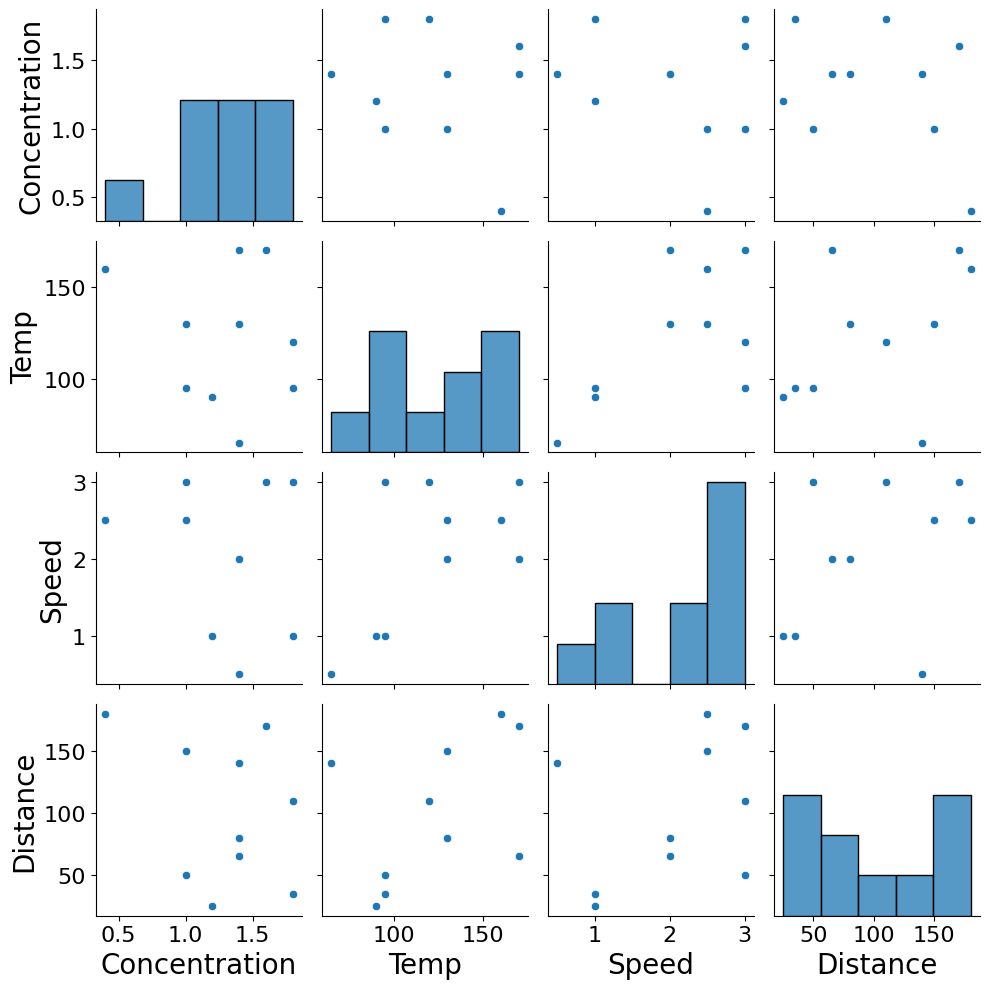

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the global font size using rcParams
plt.rc('axes', labelsize=20)    # Font size for axis labels
plt.rc('xtick', labelsize=16)   # Font size for x-axis ticks
plt.rc('ytick', labelsize=16)   # Font size for y-axis ticks
plt.figure(figsize=(10, 10), dpi=300)

# Pairwise density plots
sns.pairplot(df_X_new_random, kind='scatter', 
            #  plot_kws={'s': 100}
             )  # kde for Kernel Density Estimate
plt.tight_layout()
plt.show()

## Pairwise for Latin

<Figure size 3000x3000 with 0 Axes>

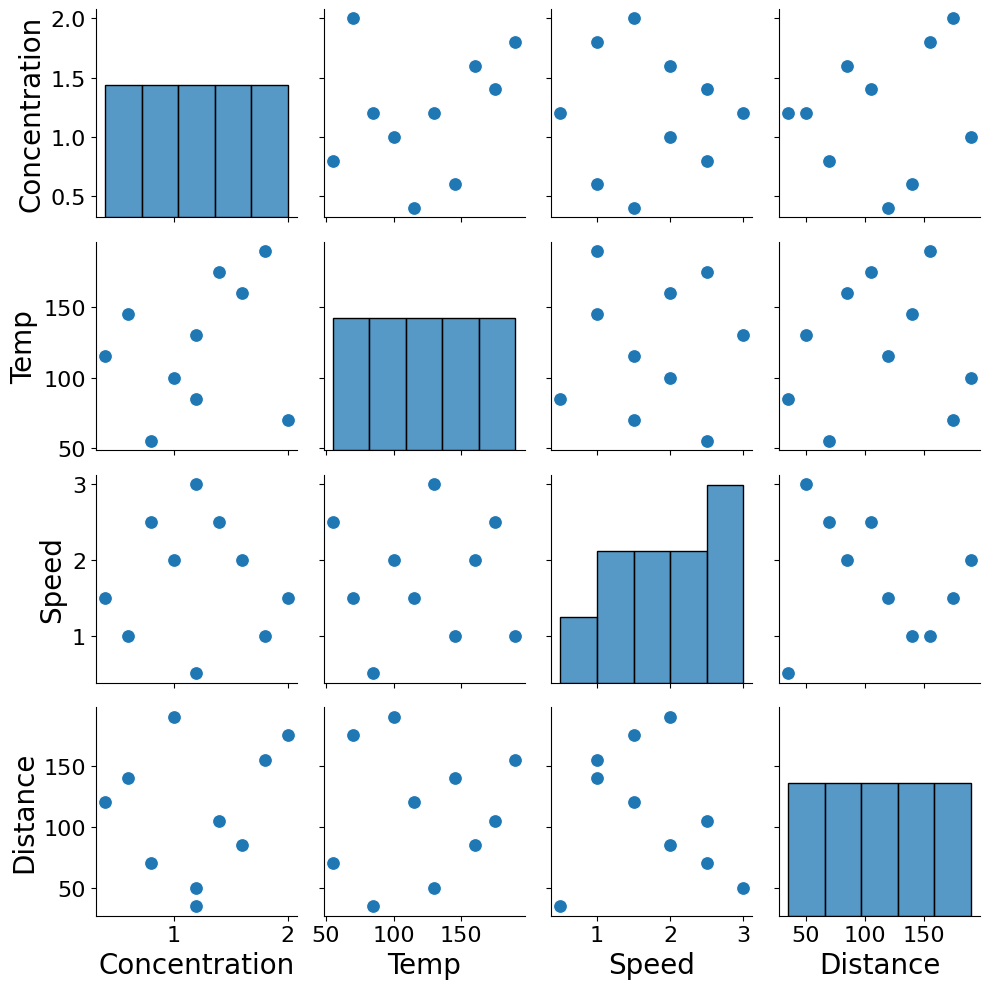

In [5]:
import seaborn as sns

# Pairwise density plots
plt.figure(figsize=(10, 10), dpi=300)
sns.pairplot(df_X_new_latin, kind='scatter', plot_kws={'s': 100}) # kde for Kernel Density Estimate\
plt.tight_layout()

plt.show()